In [38]:
#!/usr/bin/env python

import math
import random
import matplotlib.pyplot as plt
import time
%matplotlib notebook


class City():
    x_c = []
    y_c = []
    x_cF = []
    y_cF = [] 
    
    def __init__(self, x=None, y=None):
        self.x = None
        self.y = None
        if x is not None:
            self.x = x
            self.x_c.append(x) 
        else:
            self.x = int(random.random() * 200)
        if y is not None:
            self.y = y
            self.y_c.append(y)
        else:
            self.y = int(random.random() * 200)

    def getX(self):
        return self.x

    def getY(self):
        return self.y

    def distanceTo(self, city):
        xDistance = abs(self.getX() - city.getX()) 
        yDistance = abs(self.getY() - city.getY()) 
        distance = math.sqrt( (xDistance*xDistance) + (yDistance*yDistance) )
    
        return distance
        
    def __repr__(self):
        self.x_cF.append(int(self.getX()))
        self.y_cF.append(int(self.getY()))      
        return str(self.getX()) + ", " + str(self.getY())
    
    
class TourManager():
    destinationCities = []

    def addCity(self, city):
        self.destinationCities.append(city)

    def getCity(self, index):
        return self.destinationCities[index]

    def numberOfCities(self):
        return len(self.destinationCities)
    

class Tour():
    def __init__(self, tourmanager, tour=None):
        self.tourmanager = tourmanager
        self.tour = []
        self.fitness = 0.0
        self.distance = 0
        if tour is not None:
            self.tour = tour
        else:
            for i in range(0, self.tourmanager.numberOfCities()):
                self.tour.append(None)

    def __len__(self):
        return len(self.tour)

    def __getitem__(self, index):
        return self.tour[index]

    def __setitem__(self, key, value):
        self.tour[key] = value

    def __repr__(self):
        geneString = "|"
        for i in range(0, self.tourSize()):
            geneString += str(self.getCity(i)) + "|"
        return geneString

    def generateIndividual(self):
        for cityIndex in range(0, self.tourmanager.numberOfCities()):
            self.setCity(cityIndex, self.tourmanager.getCity(cityIndex))
        random.shuffle(self.tour)

    def getCity(self, tourPosition):
        return self.tour[tourPosition]

    def setCity(self, tourPosition, city):
        self.tour[tourPosition] = city
        self.fitness = 0.0
        self.distance = 0

    def getFitness(self):
        if self.fitness == 0:
            self.fitness = 1/float(self.getDistance())
        return self.fitness

    def getDistance(self):
        if self.distance == 0:
            tourDistance = 0
            for cityIndex in range(0, self.tourSize()):
                fromCity = self.getCity(cityIndex)
                destinationCity = None
                if cityIndex+1 < self.tourSize():
                    destinationCity = self.getCity(cityIndex+1)
                else:
                    destinationCity = self.getCity(0)
                tourDistance += fromCity.distanceTo(destinationCity)
            self.distance = tourDistance
        return self.distance

    def tourSize(self):
        return len(self.tour)

    def containsCity(self, city):
        return city in self.tour


class Population():
    def __init__(self, tourmanager, populationSize, initialise):
        self.tours = []
        for i in range(0, populationSize):
            self.tours.append(None)

        if initialise:
            for i in range(0, populationSize):
                newTour = Tour(tourmanager)
                newTour.generateIndividual()
                self.saveTour(i, newTour)

    def __setitem__(self, key, value):
        self.tours[key] = value

    def __getitem__(self, index):
        return self.tours[index]

    def saveTour(self, index, tour):
        self.tours[index] = tour

    def getTour(self, index):
        return self.tours[index]

    def getFittest(self):
        fittest = self.tours[0]
        for i in range(0, self.populationSize()):
            if fittest.getFitness() <= self.getTour(i).getFitness():
                fittest = self.getTour(i)
        return fittest

    def populationSize(self):
        return len(self.tours)


class GA():
    def __init__(self, tourmanager):
        self.tourmanager = tourmanager
        self.mutationRate = 0.015
        self.tournamentSize = 5
        self.elitism = True

    def evolvePopulation(self, pop):
        newPopulation = Population(self.tourmanager, pop.populationSize(), False)
        elitismOffset = 0
        if self.elitism:
            newPopulation.saveTour(0, pop.getFittest())
            elitismOffset = 1

        for i in range(elitismOffset, newPopulation.populationSize()):
            parent1 = self.tournamentSelection(pop)
            parent2 = self.tournamentSelection(pop)
            child = self.crossover(parent1, parent2)
            newPopulation.saveTour(i, child)

        for i in range(elitismOffset, newPopulation.populationSize()):
            self.mutate(newPopulation.getTour(i))

        return newPopulation

    def crossover(self, parent1, parent2):
        child = Tour(self.tourmanager)

        startPos = int(random.random() * parent1.tourSize())
        endPos = int(random.random() * parent1.tourSize())

        for i in range(0, child.tourSize()):
            if startPos < endPos and i > startPos and i < endPos:
                child.setCity(i, parent1.getCity(i))
            elif startPos > endPos:
                if not (i < startPos and i > endPos):
                    child.setCity(i, parent1.getCity(i))

        for i in range(0, parent2.tourSize()):
            if not child.containsCity(parent2.getCity(i)):
                for ii in range(0, child.tourSize()):
                    if child.getCity(ii) == None:
                        child.setCity(ii, parent2.getCity(i))
                        break

        return child

    def mutate(self, tour):
      
        for tourPos1 in range(0, tour.tourSize()):
            if random.random() < self.mutationRate:
                tourPos2 = int(tour.tourSize() * random.random())

                city1 = tour.getCity(tourPos1)
                city2 = tour.getCity(tourPos2)

                tour.setCity(tourPos2, city1)
                tour.setCity(tourPos1, city2)

    def tournamentSelection(self, pop):
        tournament = Population(self.tourmanager, self.tournamentSize, False)
        for i in range(0, self.tournamentSize):
            randomId = int(random.random() * pop.populationSize())
            tournament.saveTour(i, pop.getTour(randomId))
        fittest = tournament.getFittest()
        return fittest

if __name__ == '__main__':

    tourmanager = TourManager()

    # Create and add our cities
    city = City(165, 28) # Boa Vista
    tourmanager.addCity(city)
    city2 = City(186, 103) # Manaus
    tourmanager.addCity(city2)
    city3 = City(287, 59) # Macapa
    tourmanager.addCity(city3)
    city4 = City(315, 85) # Belem
    tourmanager.addCity(city4)
    city5 = City(363, 98) # Sao Luis
    tourmanager.addCity(city5)
    city6 = City(382, 135) # Teresina
    tourmanager.addCity(city6)
    city7 = City(425, 116) # Fortaleza
    tourmanager.addCity(city7)
    city8 = City(466, 137) # Natal
    tourmanager.addCity(city8)
    city9 = City(469, 153) # Joao Pessoa
    tourmanager.addCity(city9)
    city10 = City(467, 166) # Recife
    tourmanager.addCity(city10)
    city11 = City(443, 197) # Aracaju
    tourmanager.addCity(city11)
    city12 = City(425, 221) # Salvador
    tourmanager.addCity(city12)
    city13 = City(316, 183) # Palmas
    tourmanager.addCity(city13)
    city14 = City(225, 226) # Cuiaba
    tourmanager.addCity(city14)
    city15 = City(127, 179) # Porto Velho
    tourmanager.addCity(city15)
    city16 = City(81, 190) # Rio Branco
    tourmanager.addCity(city16)
    city17 = City(251, 322) # Campo Grande
    tourmanager.addCity(city17)
    city18 = City(298, 276) # Goiania
    tourmanager.addCity(city18)
    city19 = City(321, 258) # Distrito Federal
    tourmanager.addCity(city19)
    city20 = City(365, 315) # Belo Horizonte
    tourmanager.addCity(city20)
    city21 = City(406, 308) # Vitoria
    tourmanager.addCity(city21)
    city22 = City(370, 340) # Rio de Janeiro
    tourmanager.addCity(city22)
    city23 = City(330, 353) # Sao Paulo
    tourmanager.addCity(city23)
    city24 = City(304, 373) # Curitiba
    tourmanager.addCity(city24)
    city25 = City(308, 402) # Florianopolis
    tourmanager.addCity(city25)
    city26 = City(270, 434) # Porto Alegre
    tourmanager.addCity(city26) 

    # Initialize population
    #init_dist = str(pop.getFittest().getDistance())
    pop = Population(tourmanager, 200, True);
    print "Initial distance: " + str(pop.getFittest().getDistance())

    # Evolve population for 50 generations
    ga = GA(tourmanager)
    pop = ga.evolvePopulation(pop)

    for i in range(0, 200):
        pop = ga.evolvePopulation(pop)
        #final_dist.append(pop.getFittest().getDistance())  


    # Print final results
    print "Finished"
    print "Final distance: " + str(pop.getFittest().getDistance())
    print "Solution:"
print pop.getFittest()

Initial distance: 3993.09114356
Finished
Final distance: 1532.71120747
Solution:
|425, 116|382, 135|363, 98|315, 85|287, 59|165, 28|186, 103|127, 179|81, 190|225, 226|316, 183|321, 258|298, 276|251, 322|304, 373|270, 434|308, 402|330, 353|370, 340|365, 315|406, 308|425, 221|443, 197|467, 166|469, 153|466, 137|


In [39]:
x_c = City.x_c
y_c = City.y_c
x_cF = City.x_cF
y_cF = City.y_cF

<IPython.core.display.Javascript object>


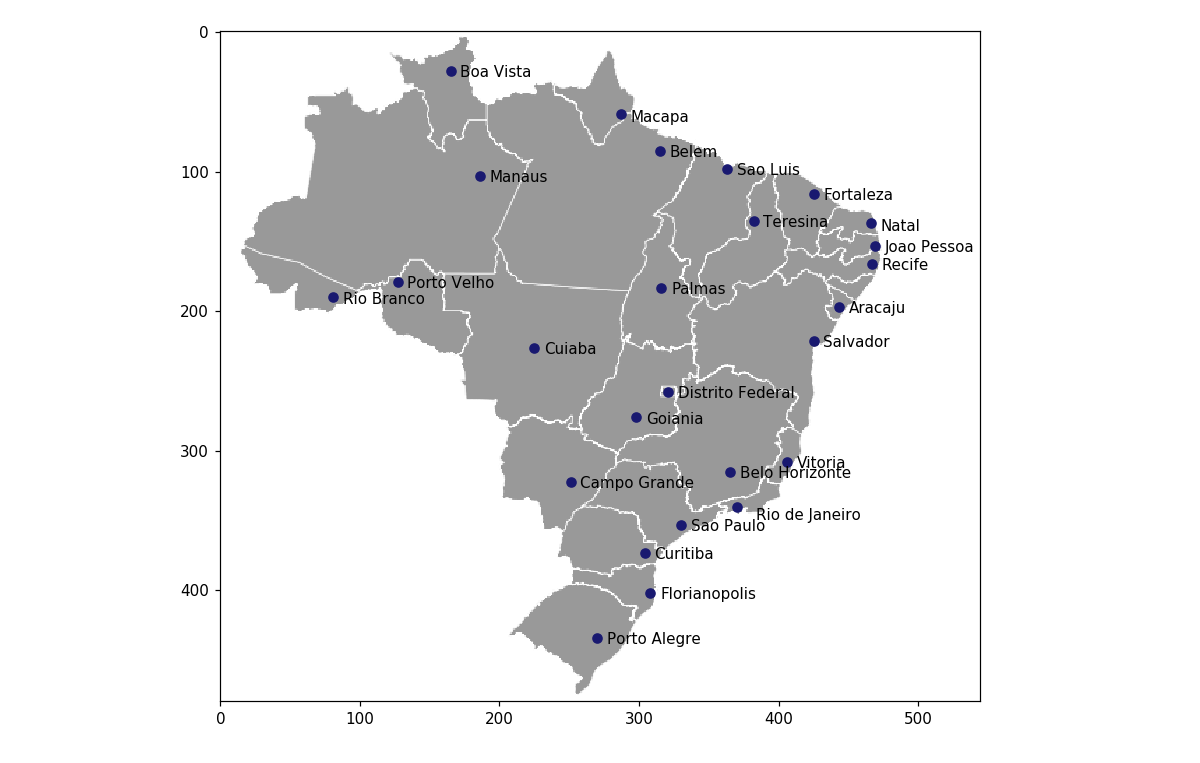

<IPython.core.display.Javascript object>


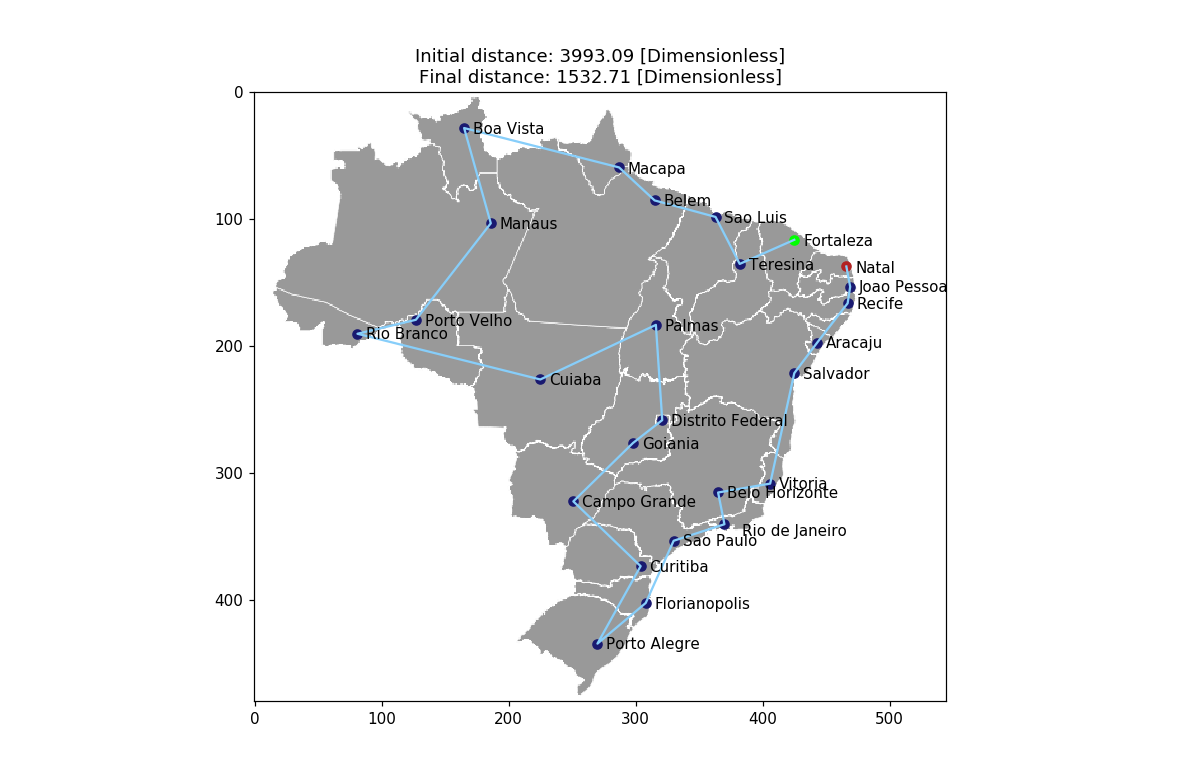

In [44]:
fig1 = plt.figure()
plt.scatter(x_c, y_c, color = '#191970')
img = plt.imread('Brazil.png')
plt.imshow(img)

plt.annotate('Boa Vista', xy=(172, 32.5))
plt.annotate('Manaus', xy=(193, 107.5))
plt.annotate('Macapa', xy=(294, 64.5)) 
plt.annotate('Belem', xy=(322, 89.5)) 
plt.annotate('Sao Luis', xy=(370, 102.5)) 
plt.annotate('Teresina', xy=(389, 139.5)) 
plt.annotate('Fortaleza', xy=(432, 120.5)) 
plt.annotate('Natal', xy=(473, 142.5))
plt.annotate('Joao Pessoa', xy=(476, 157.5)) 
plt.annotate('Recife', xy=(474, 170.5))
plt.annotate('Aracaju', xy=(450, 201.5)) 
plt.annotate('Salvador', xy=(432, 225.5)) 
plt.annotate('Palmas', xy=(323, 187.5))
plt.annotate('Cuiaba', xy=(232, 230.5)) 
plt.annotate('Porto Velho', xy=(134, 183.5)) 
plt.annotate('Rio Branco', xy=(88, 194.5))
plt.annotate('Campo Grande', xy=(258, 326.5)) 
plt.annotate('Goiania', xy=(305, 280.5)) 
plt.annotate('Distrito Federal', xy=(328, 262.5)) 
plt.annotate('Belo Horizonte', xy=(372, 319.5))
plt.annotate('Vitoria', xy=(413, 312.5))
plt.annotate('Rio de Janeiro', xy=(384, 349.5)) 
plt.annotate('Sao Paulo', xy=(337, 357.5))
plt.annotate('Curitiba', xy=(311, 377.5)) 
plt.annotate('Florianopolis', xy=(315, 406.5)) 
plt.annotate('Porto Alegre', xy=(277, 438.5)) 

fig1.tight_layout()
fig1_name = 'fig1.png'
fig1.set_size_inches(w=11,h=7)
fig1.savefig(fig1_name)


fig2 = plt.figure()
plt.plot(x_cF, y_cF , color = '#87CEFA')
plt.scatter(x_cF[0], y_cF[0], color = '#00FF00')
plt.scatter(x_cF[1:-1], y_cF[1:-1], color = '#191970')
plt.scatter(x_cF[-1], y_cF[-1], color = '#B22222')
img = plt.imread('Brazil.png')
plt.imshow(img)
plt.title('Initial distance: 3993.09 [Dimensionless]'+'\nFinal distance: 1532.71 [Dimensionless]')

plt.annotate('Boa Vista', xy=(172, 32.5))
plt.annotate('Manaus', xy=(193, 107.5))
plt.annotate('Macapa', xy=(294, 64.5)) 
plt.annotate('Belem', xy=(322, 89.5)) 
plt.annotate('Sao Luis', xy=(370, 102.5)) 
plt.annotate('Teresina', xy=(389, 139.5)) 
plt.annotate('Fortaleza', xy=(432, 120.5)) 
plt.annotate('Natal', xy=(473, 142.5))
plt.annotate('Joao Pessoa', xy=(476, 157.5)) 
plt.annotate('Recife', xy=(474, 170.5))
plt.annotate('Aracaju', xy=(450, 201.5)) 
plt.annotate('Salvador', xy=(432, 225.5)) 
plt.annotate('Palmas', xy=(323, 187.5))
plt.annotate('Cuiaba', xy=(232, 230.5)) 
plt.annotate('Porto Velho', xy=(134, 183.5)) 
plt.annotate('Rio Branco', xy=(88, 194.5))
plt.annotate('Campo Grande', xy=(258, 326.5)) 
plt.annotate('Goiania', xy=(305, 280.5)) 
plt.annotate('Distrito Federal', xy=(328, 262.5)) 
plt.annotate('Belo Horizonte', xy=(372, 319.5))
plt.annotate('Vitoria', xy=(413, 312.5))
plt.annotate('Rio de Janeiro', xy=(384, 349.5)) 
plt.annotate('Sao Paulo', xy=(337, 357.5))
plt.annotate('Curitiba', xy=(311, 377.5)) 
plt.annotate('Florianopolis', xy=(315, 406.5)) 
plt.annotate('Porto Alegre', xy=(277, 438.5)) 

fig2.tight_layout()
fig2_name = 'fig2.png'
fig2.set_size_inches(w=11,h=7)
fig2.savefig(fig2_name)